<a href="https://colab.research.google.com/github/Keqing1109/api/blob/main/RSM8413/A1/Group_Work_PythonScript_ML_Group_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Pre-processing**

In [1]:
!pip install duckdb
!pip install pandas
!pip install yfinance

In [2]:
# Setup the imports
import duckdb
import pandas as pd
import yfinance as yf

In [4]:
df = pd.read_excel("ebayAuctions.xlsx", sheet_name="eBay auctions")
result = duckdb.query("SELECT * FROM df").to_df()

In [5]:
# Create a new table to work with for processed data
duckdb.query("CREATE TABLE new_df AS SELECT * FROM df")

In [6]:
# There's alot more US than GBP
duckdb.query("SELECT Currency, Count(Currency) FROM new_df GROUP BY Currency").to_df()

,Currency,count(Currency)
0,US,1292
1,GBP,147
2,EUR,533


In [7]:
# Get average May-June EUR
ticker = yf.Ticker("EURUSD=X")
data = ticker.history(start="2004-05-01", end="2004-06-30")
eur_avg_rate = round(data["Close"].mean(), 2)
# Get average May-June GBP
data = yf.Ticker("GBPUSD=X").history(start="2004-05-01", end="2004-06-30")
gbp_avg_rate = round(data["Close"].mean(), 2)

In [8]:
# Create columns so that all close and open prices are in american dollars
duckdb.query("ALTER TABLE new_df ADD COLUMN ClosePriceUSD NUMERIC")
duckdb.query("ALTER TABLE new_df ADD COLUMN OpenPriceUSD NUMERIC")

In [9]:
# call the update twice, one on EUR and one on GBP
duckdb.query(f"UPDATE new_df SET ClosePriceUSD=ROUND(ClosePrice*{eur_avg_rate},2) WHERE Currency='EUR'")
duckdb.query(f"UPDATE new_df SET ClosePriceUSD=ROUND(ClosePrice*{gbp_avg_rate},2) WHERE Currency='GBP'")

In [10]:
# call the update twice, one on EUR and one on GBP
duckdb.query(f"UPDATE new_df SET OpenPriceUSD=ROUND(OpenPrice*{eur_avg_rate},2) WHERE Currency='EUR'")
duckdb.query(f"UPDATE new_df SET OpenPriceUSD=ROUND(OpenPrice*{gbp_avg_rate},2) WHERE Currency='GBP'")

In [11]:
# Add in the US col but do nothing
duckdb.query("UPDATE new_df SET ClosePriceUSD=ROUND(ClosePrice, 2) WHERE Currency='US'")
duckdb.query("UPDATE new_df SET OpenPriceUSD=ROUND(OpenPrice, 2) WHERE Currency='US'")

In [12]:
# Create a new df to work with when SQL is viable anymore
new_df = duckdb.query("SELECT * FROM new_df").to_df()

In [13]:
# Map the days
new_df["endDay"] = new_df["endDay"].map({'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6})
# One-hot encode category and currency
df_encoded = pd.get_dummies(new_df, columns=["Category", "Currency"])
# Create a column for the difference between opening and close
df_encoded["CloseOpenDifference"] = df_encoded["ClosePriceUSD"] - df_encoded["OpenPriceUSD"]

In [14]:
# Write to a new dataframe
df_encoded.to_excel("ebayAuctionsCleaned.xlsx", index=False)

## **Exploratory Data Analysis(EDA)**

In [15]:
df_encoded.head()

,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?,ClosePriceUSD,OpenPriceUSD,Category_Antique/Art/Craft,Category_Automotive,...,Category_Jewelry,Category_Music/Movie/Game,Category_Photography,Category_Pottery/Glass,Category_SportingGoods,Category_Toys/Hobbies,Currency_EUR,Currency_GBP,Currency_US,CloseOpenDifference
0,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0
1,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0
2,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0
3,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0
4,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

In [17]:
auction_cleaned = df_encoded # read cleaned auction data
auction = pd.read_excel("ebayAuctions.xlsx",sheet_name="eBay auctions") # read original data

In [18]:
auction_cleaned.head() # view the data

,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?,ClosePriceUSD,OpenPriceUSD,Category_Antique/Art/Craft,Category_Automotive,...,Category_Jewelry,Category_Music/Movie/Game,Category_Photography,Category_Pottery/Glass,Category_SportingGoods,Category_Toys/Hobbies,Currency_EUR,Currency_GBP,Currency_US,CloseOpenDifference
0,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0
1,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0
2,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0
3,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0
4,3249,5,0,0.01,0.01,0,0.01,0.01,False,False,...,False,True,False,False,False,False,False,False,True,0.0


In [19]:
auction_cleaned.describe() # provide descriptive analysis

,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?,ClosePriceUSD,OpenPriceUSD,CloseOpenDifference
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,2.970588,36.449087,12.926268,0.540568,39.428971,13.578205,25.850766
std,5973.011033,2.052906,2.299526,89.493858,38.856149,0.498478,95.671901,39.414209,85.173718
min,0.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.010000,0.010000,0.000000
25%,595.000000,5.000000,0.000000,4.907500,1.230000,0.000000,4.990000,1.490000,0.000000
50%,1853.000000,7.000000,3.000000,9.995000,4.500000,1.000000,11.170000,4.990000,0.815000
75%,3380.000000,7.000000,5.000000,28.000000,9.990000,1.000000,30.990000,11.020000,14.570000
max,37727.000000,10.000000,6.000000,999.000000,999.000000,1.000000,1044.570000,999.000000,1043.080000


In [20]:
auction_cleaned.endDay.unique() # Encode the endDay, 0 = Monday ~ 6 = Sunday

array([0, 1, 4, 3, 5, 6, 2])

In [21]:
num_auction = auction_cleaned.select_dtypes(include=['number']) # only select numerical columns

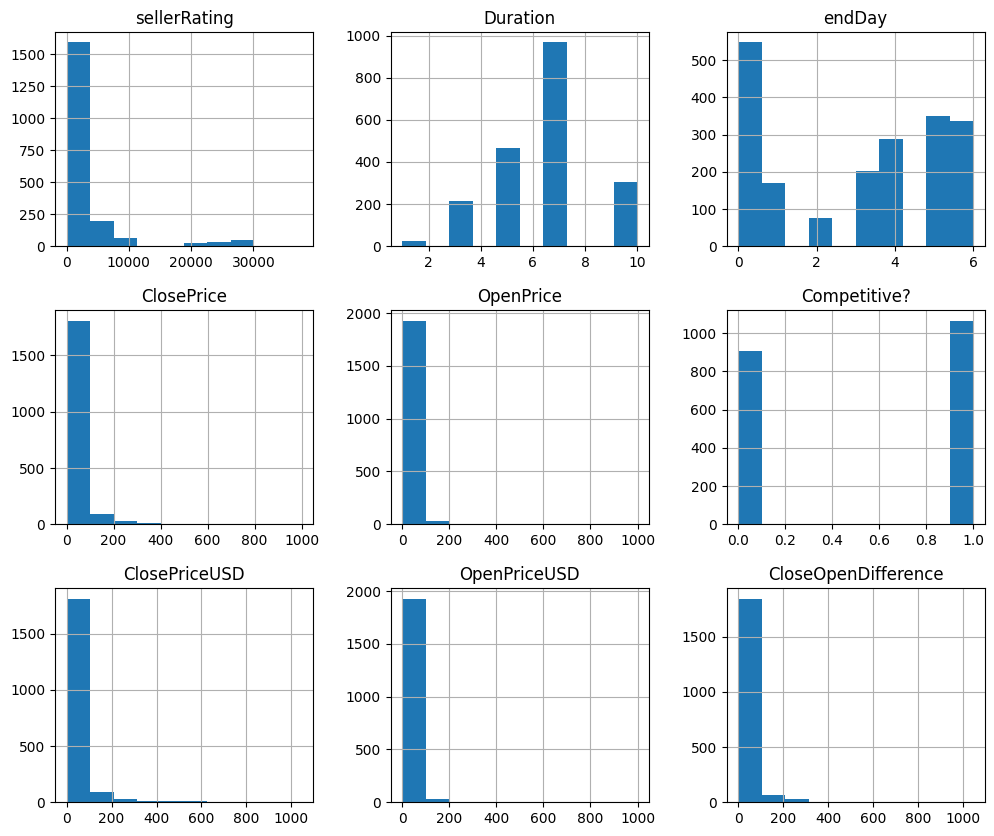

In [22]:
auction_cleaned.hist(figsize=(12,10)) #plot histogram for all the numeric variables
plt.show()

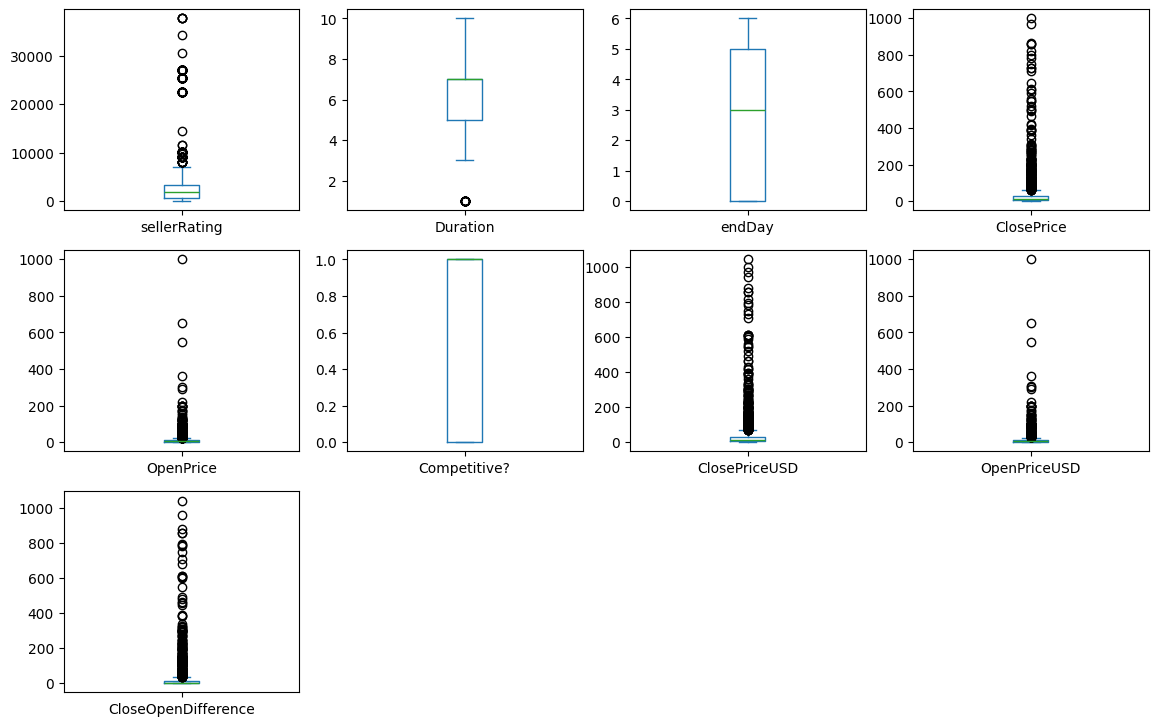

In [23]:
auction_cleaned.plot(kind="box", subplots=True, layout = (4,4),figsize=(14,12))
plt.show()

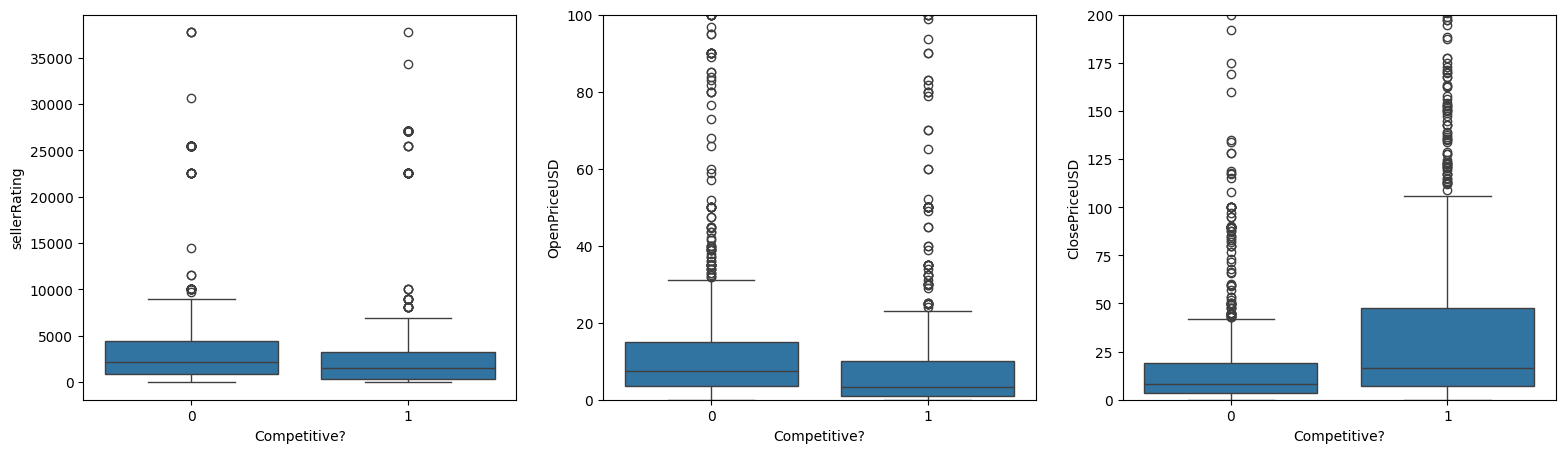

In [24]:
fig,axes = plt.subplots(1,3,figsize = (19,5))
sns.boxplot(data=auction_cleaned, x='Competitive?', y='sellerRating',ax= axes[0])
sns.boxplot(data=auction_cleaned, x='Competitive?', y='OpenPriceUSD',ax= axes[1]) # y rescealed
sns.boxplot(data=auction_cleaned, x='Competitive?', y='ClosePriceUSD',ax= axes[2]) # y rescealed
axes[1].set_ylim(0,100)
axes[2].set_ylim(0,200)
plt.show()


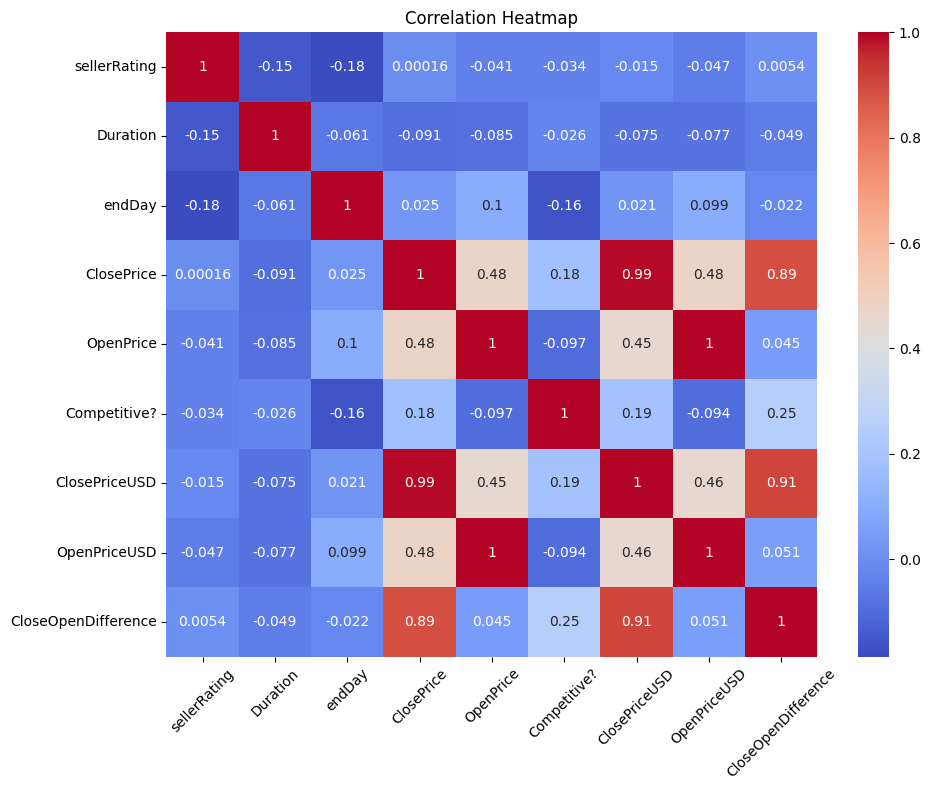

In [25]:
plt.figure(figsize=(10,8))
# Compute correlation matrix
corr = num_auction.corr(numeric_only=True)

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

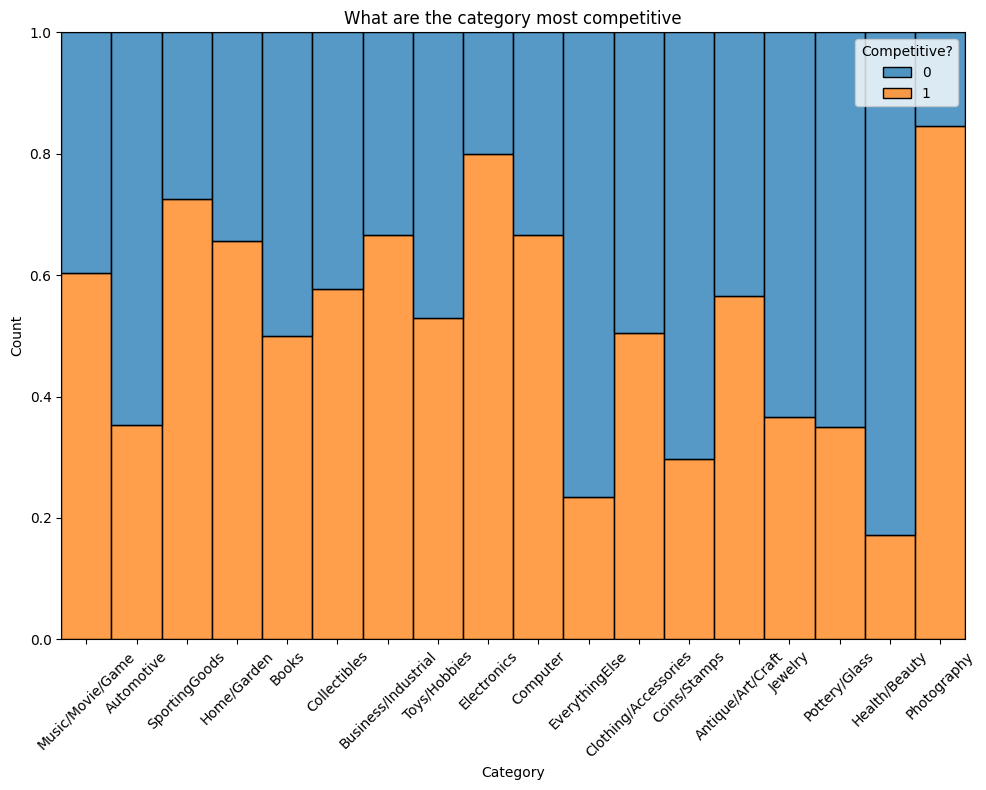

In [26]:
plt.figure(figsize = (10,8))
sns.histplot(data = auction, x = "Category", hue = "Competitive?", multiple = "fill")
plt.title("What are the category most competitive")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

<Axes: ylabel='Currency'>

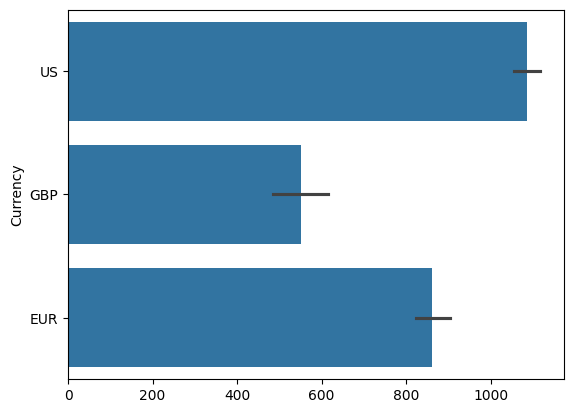

In [27]:
sns.barplot(data = auction.Currency) # plot proportion of each currncy

<Axes: xlabel='Competitive?', ylabel='Count'>

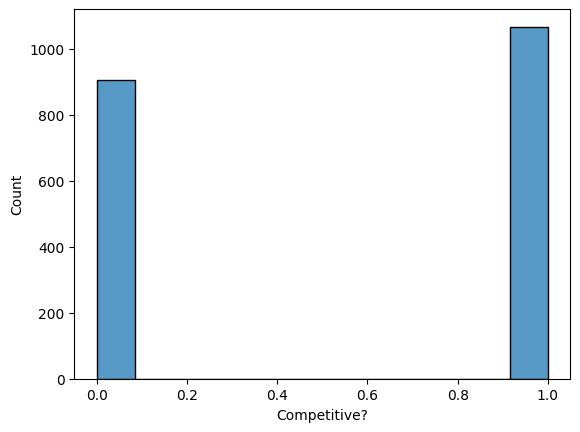

In [28]:
sns.histplot(data = auction["Competitive?"])

Model: KNN

In [29]:
import numpy as np
import pandas as pd
from numpy import arange
from pandas import read_table
from pandas import set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [30]:
data = df_encoded
data = data.drop(["OpenPrice", "ClosePrice", "Currency_EUR", "Currency_GBP", "Currency_US"], axis = 1)

In [31]:
X = data.drop("Competitive?", axis =1)
X

,sellerRating,Duration,endDay,ClosePriceUSD,OpenPriceUSD,Category_Antique/Art/Craft,Category_Automotive,Category_Books,Category_Business/Industrial,Category_Clothing/Accessories,...,Category_EverythingElse,Category_Health/Beauty,Category_Home/Garden,Category_Jewelry,Category_Music/Movie/Game,Category_Photography,Category_Pottery/Glass,Category_SportingGoods,Category_Toys/Hobbies,CloseOpenDifference
0,3249,5,0,0.01,0.01,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
1,3249,5,0,0.01,0.01,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
2,3249,5,0,0.01,0.01,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
3,3249,5,0,0.01,0.01,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
4,3249,5,0,0.01,0.01,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,2992,5,6,359.95,359.95,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0.0
1968,21,5,5,610.00,300.00,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,310.0
1969,1400,5,0,549.00,549.00,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0.0
1970,57,7,4,820.00,650.00,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,170.0


In [32]:
y = data["Competitive?"]
y

,Competitive?
0,0
1,0
2,0
3,0
4,0
...,...
1967,0
1968,1
1969,0
1970,1


In [33]:
seed = 104
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = seed)

## Standardizing features

In [34]:
scaler = StandardScaler()

In [35]:
X_train_scaled = scaler.fit_transform(X_train)

In [36]:
X_test_scaled = scaler.transform(X_test)

Tone K parameter using CV

In [37]:
k_value = np.arange(1, 31)

In [38]:
num_folds = 10

In [39]:
param_grid = dict(n_neighbors = k_value)

In [40]:
model = KNeighborsClassifier()

In [41]:
scoring = 'f1'

In [42]:
kfold = KFold(n_splits = num_folds, shuffle = True, random_state = seed)

In [43]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

In [44]:
grid_result = grid.fit(X_train_scaled, y_train)

In [45]:
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Best: 0.784860 using {'n_neighbors': np.int64(1)}


In [46]:
optimal_k = grid_result.best_params_['n_neighbors']

In [47]:
print(optimal_k)

1


In [48]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f(%f) with: %r" % (mean,stdev, param))

0.784860(0.026592) with: {'n_neighbors': np.int64(1)}
0.705428(0.042294) with: {'n_neighbors': np.int64(2)}
0.728598(0.027965) with: {'n_neighbors': np.int64(3)}
0.703881(0.040116) with: {'n_neighbors': np.int64(4)}
0.737284(0.040351) with: {'n_neighbors': np.int64(5)}
0.704144(0.034926) with: {'n_neighbors': np.int64(6)}
0.736713(0.024845) with: {'n_neighbors': np.int64(7)}
0.704996(0.033116) with: {'n_neighbors': np.int64(8)}
0.731268(0.030532) with: {'n_neighbors': np.int64(9)}
0.711766(0.027637) with: {'n_neighbors': np.int64(10)}
0.721938(0.037458) with: {'n_neighbors': np.int64(11)}
0.700299(0.043309) with: {'n_neighbors': np.int64(12)}
0.712743(0.035053) with: {'n_neighbors': np.int64(13)}
0.692829(0.042482) with: {'n_neighbors': np.int64(14)}
0.718625(0.036646) with: {'n_neighbors': np.int64(15)}
0.700961(0.040938) with: {'n_neighbors': np.int64(16)}
0.702394(0.037621) with: {'n_neighbors': np.int64(17)}
0.692802(0.035602) with: {'n_neighbors': np.int64(18)}
0.710002(0.038295) 

In [49]:
final_knn = KNeighborsClassifier(n_neighbors= optimal_k)
final_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=np.int64(1))

In [50]:
y_pred = final_knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

In [51]:
print(f"Test Accuracy: {test_accuracy:.4f}\n")

Test Accuracy: 0.8215



In [52]:
print("Classification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Not Competitive', 'Competitive']))

Classification Report:
                 precision    recall  f1-score   support

Not Competitive       0.80      0.79      0.80       216
    Competitive       0.84      0.84      0.84       277

       accuracy                           0.82       493
      macro avg       0.82      0.82      0.82       493
   weighted avg       0.82      0.82      0.82       493



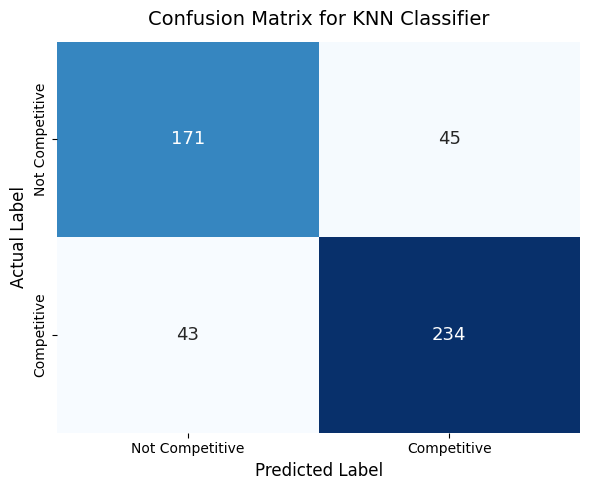

In [53]:
cm = confusion_matrix(y_test, y_pred)

labels = ['Not Competitive', 'Competitive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, annot_kws={"size": 13})

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.title('Confusion Matrix for KNN Classifier', fontsize=14, pad=12)
plt.tight_layout()
plt.show()

In [54]:
train_accuracy = final_knn.score(X_train_scaled, y_train)
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Difference: {abs(train_accuracy - test_accuracy):.4f}")


Train Accuracy: 0.9885
Test Accuracy: 0.8215
Difference: 0.1670


# Model: Decision Tree


In [55]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
columns_to_drop = ['Currency_EUR', 'Currency_GBP', 'Currency_US', 'ClosePrice', 'OpenPrice',"CloseOpenDifference"]
df_clean = df_encoded.drop(columns=columns_to_drop)

In [57]:
X = df_clean.drop(['Competitive?'], axis=1)
y = df_clean['Competitive?']

In [58]:
print(df_clean.columns)

Index(['sellerRating', 'Duration', 'endDay', 'Competitive?', 'ClosePriceUSD',
       'OpenPriceUSD', 'Category_Antique/Art/Craft', 'Category_Automotive',
       'Category_Books', 'Category_Business/Industrial',
       'Category_Clothing/Accessories', 'Category_Coins/Stamps',
       'Category_Collectibles', 'Category_Computer', 'Category_Electronics',
       'Category_EverythingElse', 'Category_Health/Beauty',
       'Category_Home/Garden', 'Category_Jewelry', 'Category_Music/Movie/Game',
       'Category_Photography', 'Category_Pottery/Glass',
       'Category_SportingGoods', 'Category_Toys/Hobbies'],
      dtype='object')


In [59]:
print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Competitive rate: {y.mean():.3f}")

Features shape: (1972, 23)
Target distribution:
Competitive?
1    1066
0     906
Name: count, dtype: int64
Competitive rate: 0.541


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [61]:
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1380, 23)
Test set: (592, 23)


In [62]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=50,random_state=42,max_depth=10) # Minimum 50 records per leaf node

In [63]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, random_state=42)

In [64]:
y_pred = dt_clf.predict(X_test)

In [65]:
train_accuracy = dt_clf.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

Training Accuracy: 0.846
Test Accuracy: 0.816


In [66]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Competitive', 'Competitive']))


Classification Report:
                 precision    recall  f1-score   support

Not Competitive       0.77      0.86      0.81       272
    Competitive       0.87      0.78      0.82       320

       accuracy                           0.82       592
      macro avg       0.82      0.82      0.82       592
   weighted avg       0.82      0.82      0.82       592



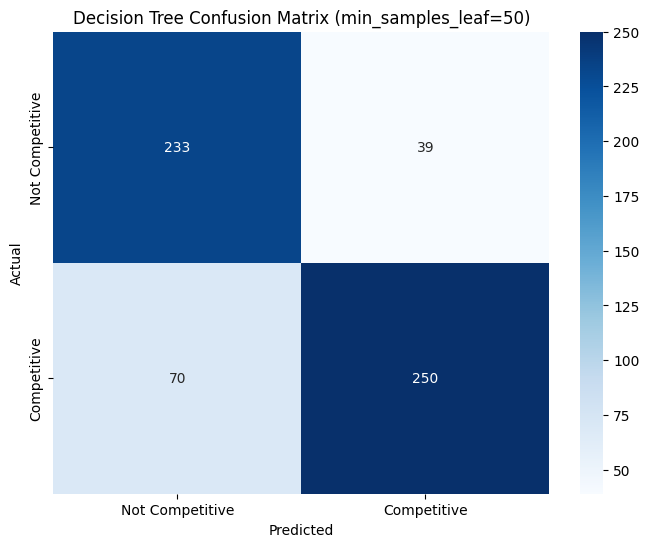

In [67]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Competitive', 'Competitive'],
            yticklabels=['Not Competitive', 'Competitive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Decision Tree Confusion Matrix (min_samples_leaf=50)')
plt.show()

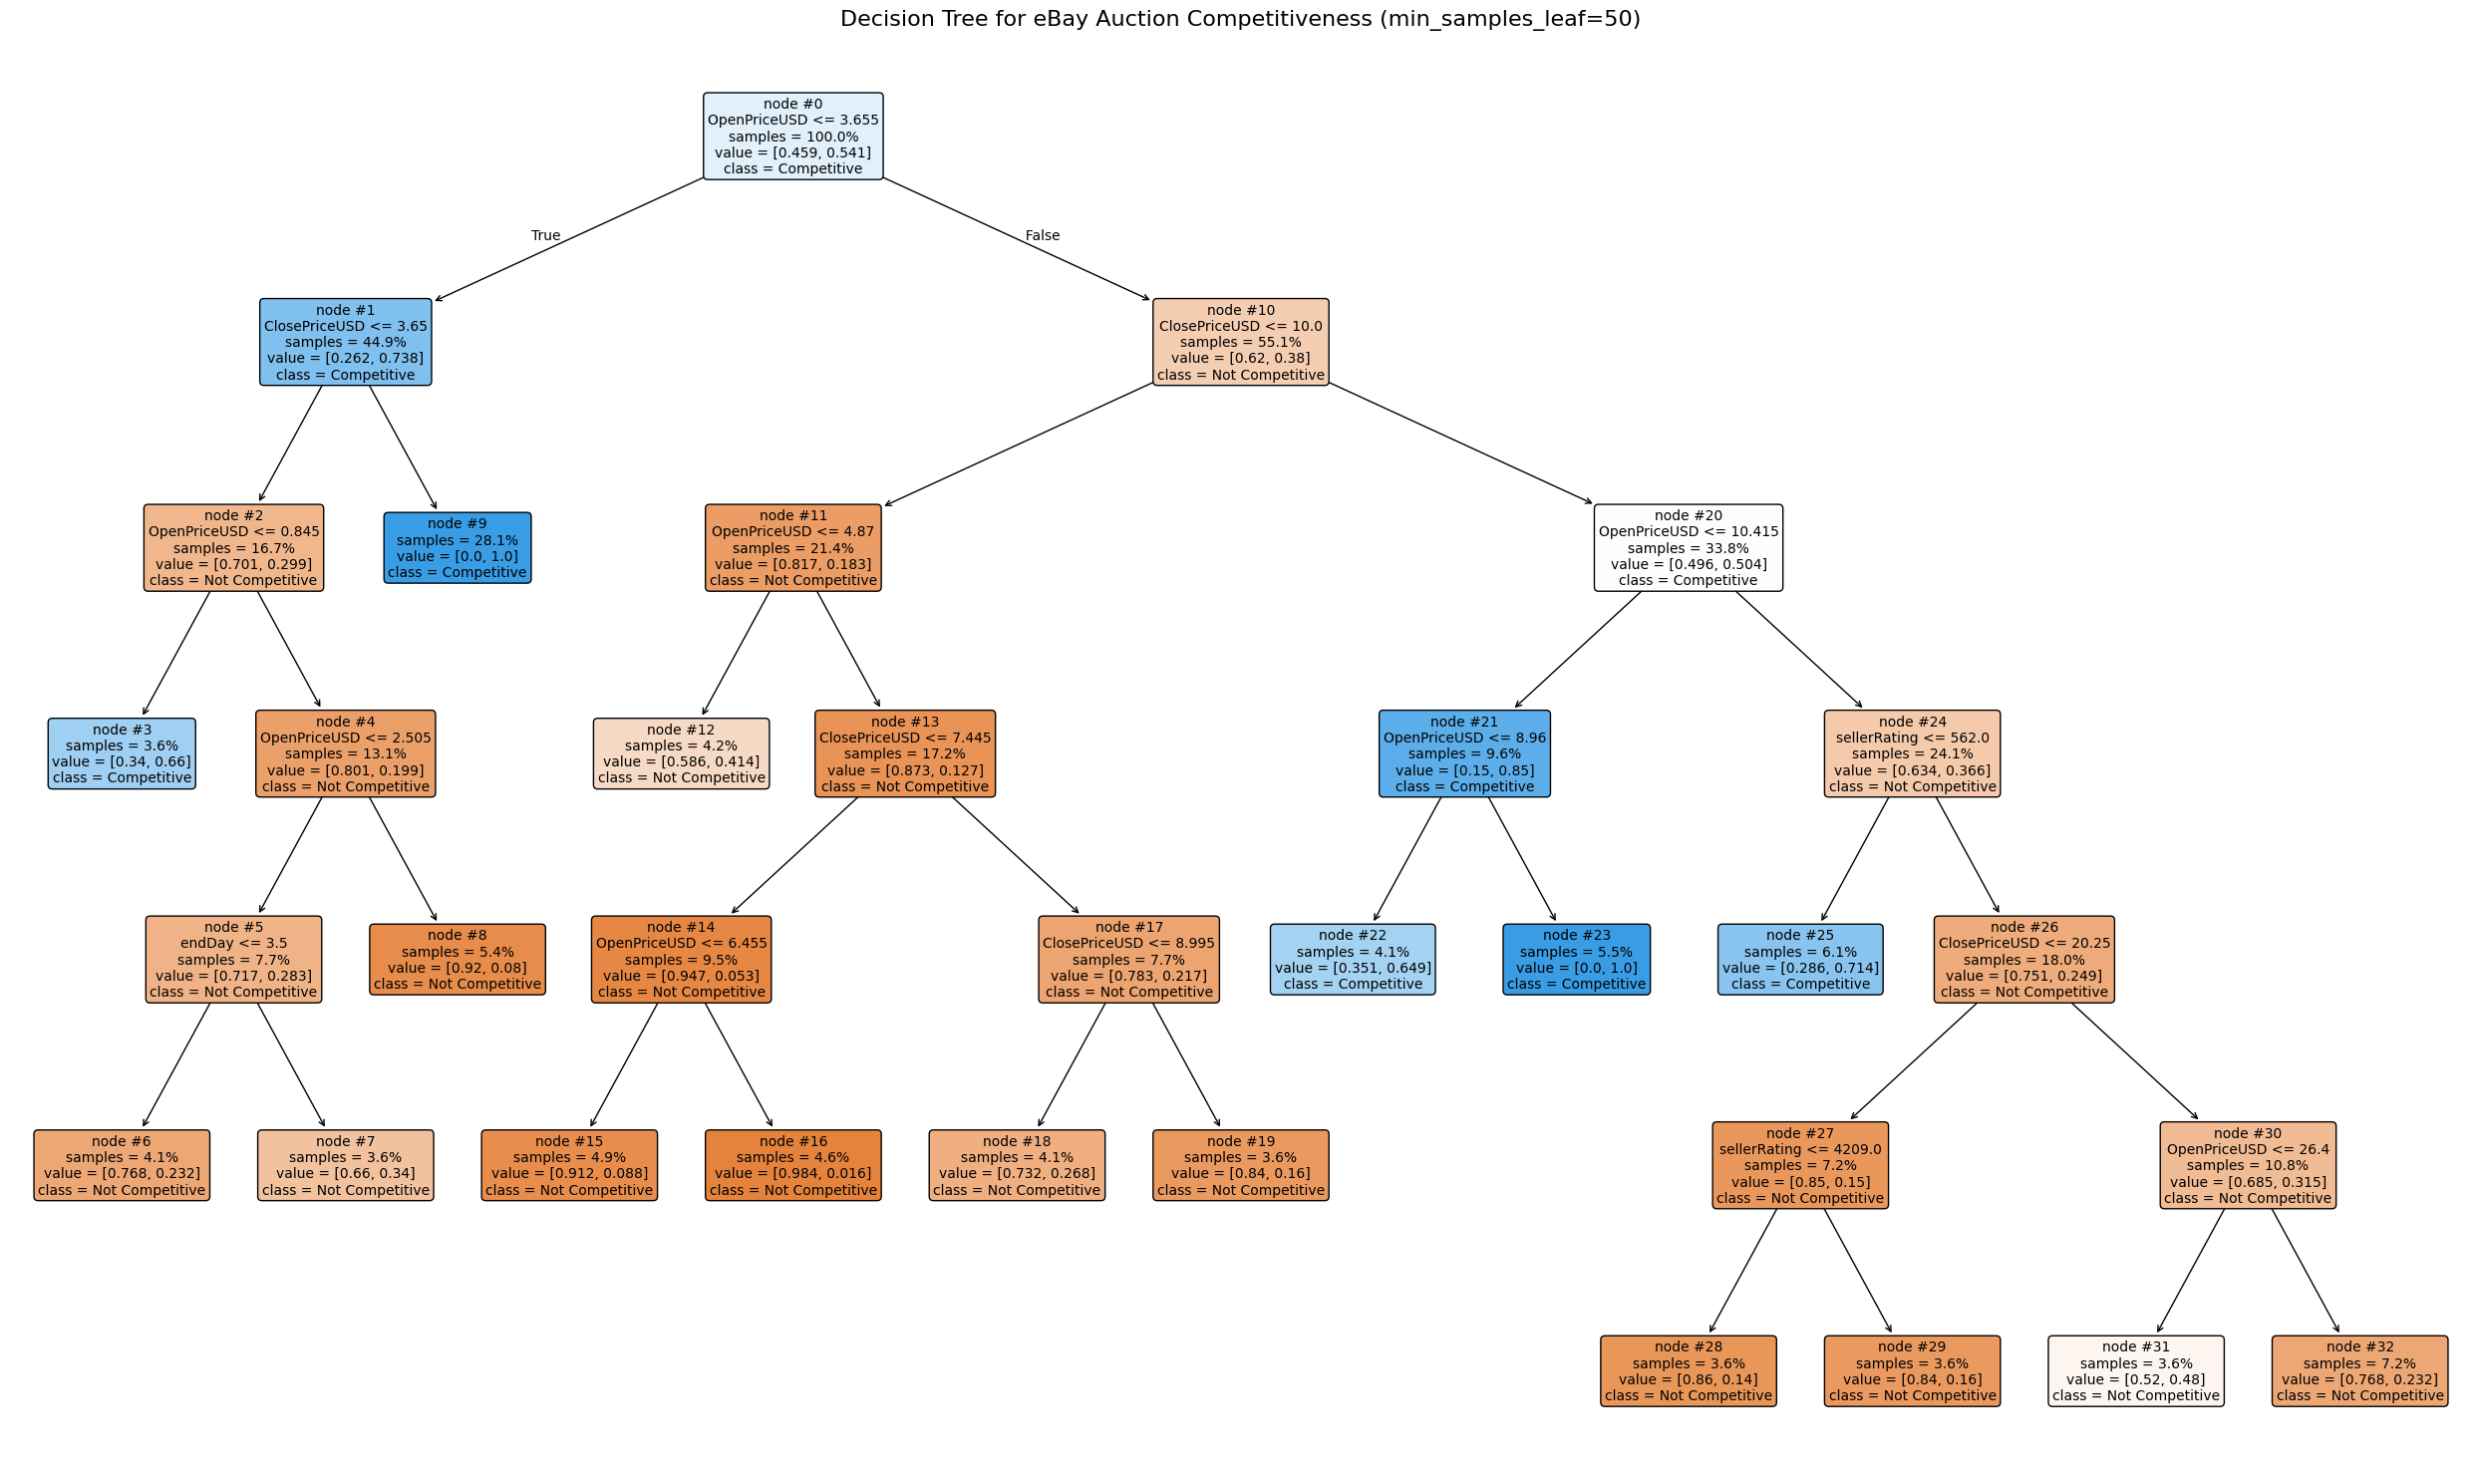

In [68]:
# Plot the decision tree
plt.figure(figsize=(25, 15))
plot_tree(dt_clf,
          feature_names=X.columns.tolist(),
          class_names=['Not Competitive', 'Competitive'],
          rounded=True,
          fontsize=10,
          filled=True, node_ids=True, proportion=True, label='all', impurity=False
)

plt.title('Decision Tree for eBay Auction Competitiveness (min_samples_leaf=50)', fontsize=16)
plt.tight_layout()
plt.show()

In [69]:
# Get feature importance
feature_importance = pd.DataFrame({'feature': X.columns,'importance': dt_clf.feature_importances_}).sort_values('importance', ascending=False)
print(feature_importance.head(5))

         feature  importance
3  ClosePriceUSD    0.482372
4   OpenPriceUSD    0.445735
0   sellerRating    0.070306
2         endDay    0.001588
1       Duration    0.000000


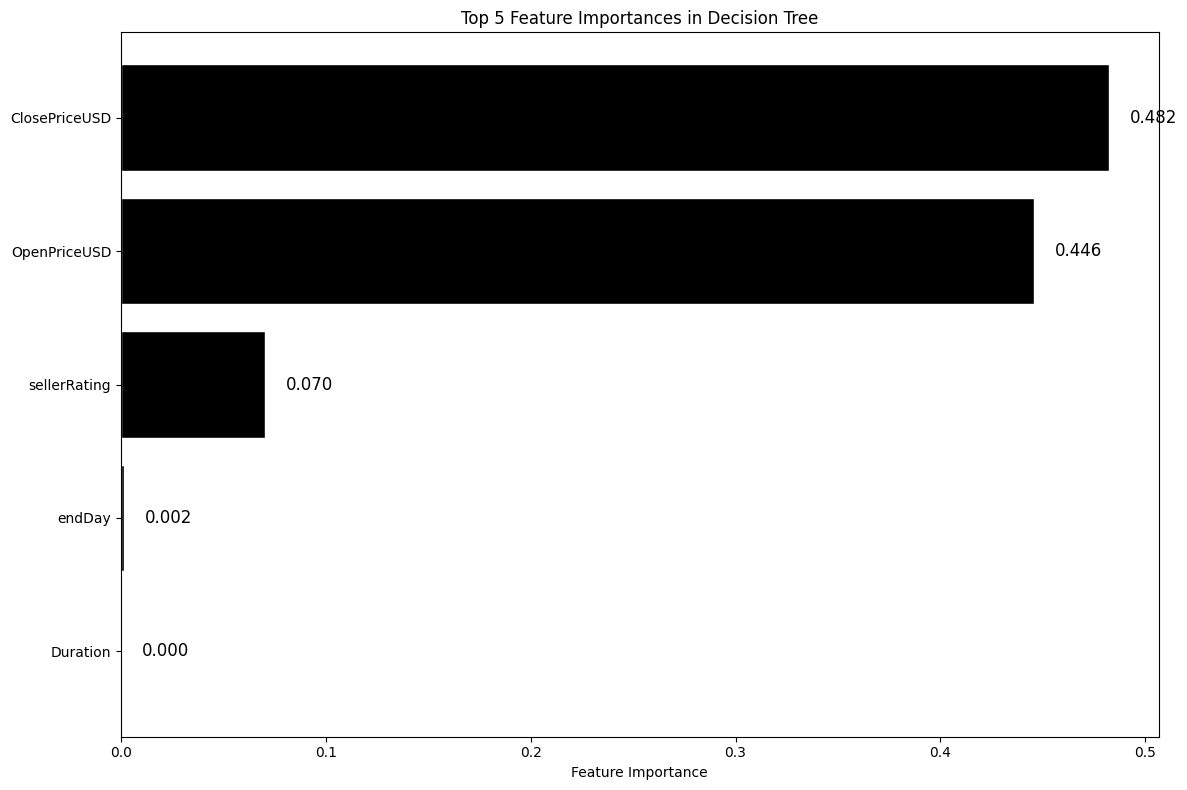

In [70]:
# Plot feature importance with the importance values
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(5)
bars = plt.barh(top_features['feature'], top_features['importance'], color='black', edgecolor='white')
plt.xlabel('Feature Importance')
plt.title('Top 5 Feature Importances in Decision Tree')
plt.gca().invert_yaxis()
for bar, imp in zip(bars, top_features['importance']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{imp:.3f}", va='center', fontsize=12)
plt.tight_layout()
plt.show()


In [71]:
# Show features with zero importance(i.e. features with little influence to prediction result)
zero_importance_features = feature_importance[feature_importance['importance'] == 0]
print(zero_importance_features['feature'].tolist())

['Duration', 'Category_Antique/Art/Craft', 'Category_Automotive', 'Category_Books', 'Category_Business/Industrial', 'Category_Clothing/Accessories', 'Category_Coins/Stamps', 'Category_Collectibles', 'Category_Computer', 'Category_Electronics', 'Category_EverythingElse', 'Category_Health/Beauty', 'Category_Home/Garden', 'Category_Jewelry', 'Category_Music/Movie/Game', 'Category_Photography', 'Category_Pottery/Glass', 'Category_SportingGoods', 'Category_Toys/Hobbies']


In [72]:
df_clean

,sellerRating,Duration,endDay,Competitive?,ClosePriceUSD,OpenPriceUSD,Category_Antique/Art/Craft,Category_Automotive,Category_Books,Category_Business/Industrial,...,Category_Electronics,Category_EverythingElse,Category_Health/Beauty,Category_Home/Garden,Category_Jewelry,Category_Music/Movie/Game,Category_Photography,Category_Pottery/Glass,Category_SportingGoods,Category_Toys/Hobbies
0,3249,5,0,0,0.01,0.01,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,3249,5,0,0,0.01,0.01,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,3249,5,0,0,0.01,0.01,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,3249,5,0,0,0.01,0.01,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,3249,5,0,0,0.01,0.01,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,2992,5,6,0,359.95,359.95,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1968,21,5,5,1,610.00,300.00,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1969,1400,5,0,0,549.00,549.00,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1970,57,7,4,1,820.00,650.00,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


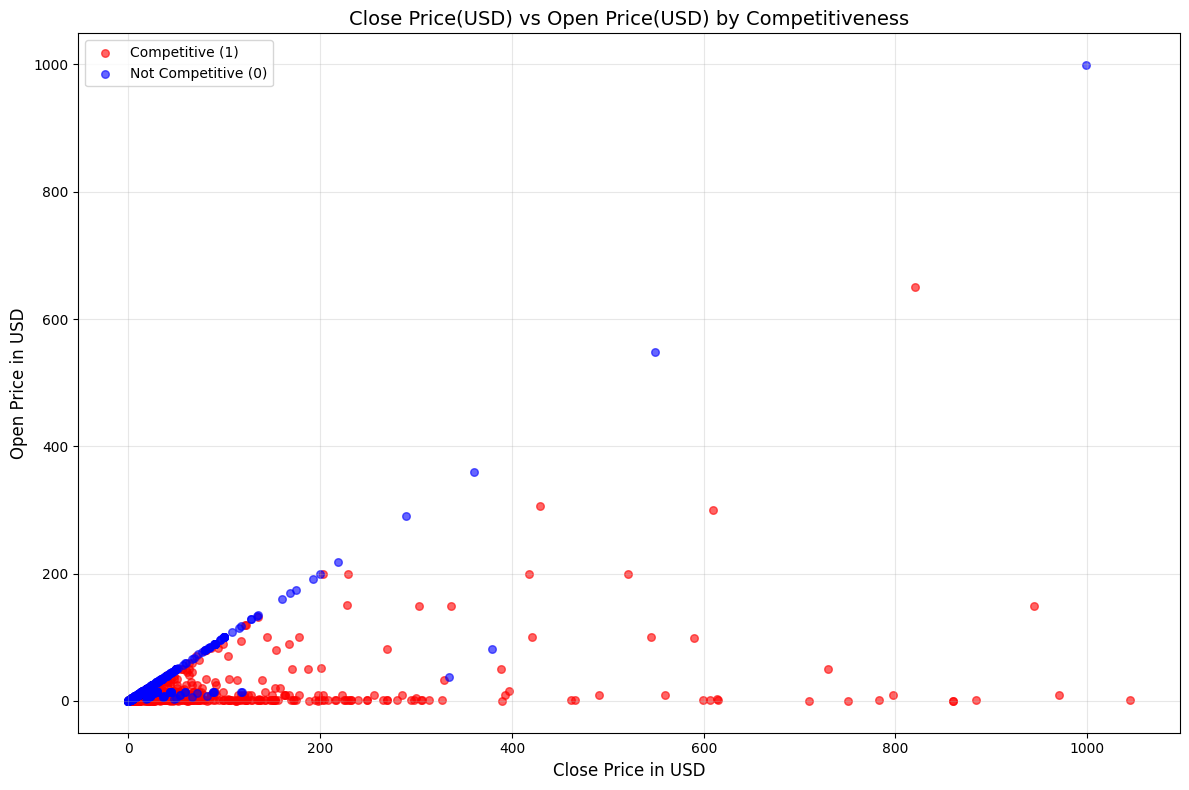

In [73]:
plt.figure(figsize=(12, 8)) # Create the scatter plot
# Competitive:
plt.scatter(df_clean[df_clean['Competitive?'] == 1]['ClosePriceUSD'],
            df_clean[df_clean['Competitive?'] == 1]['OpenPriceUSD'],
            c='red', alpha=0.6, label='Competitive (1)', s=30)

#non-Competitive:
plt.scatter(df_clean[df_clean['Competitive?'] == 0]['ClosePriceUSD'],
            df_clean[df_clean['Competitive?'] == 0]['OpenPriceUSD'],
            c='blue', alpha=0.6, label='Not Competitive (0)', s=30)

plt.xlabel('Close Price in USD', fontsize=12)
plt.ylabel('Open Price in USD', fontsize=12)
plt.title('Close Price(USD) vs Open Price(USD) by Competitiveness', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

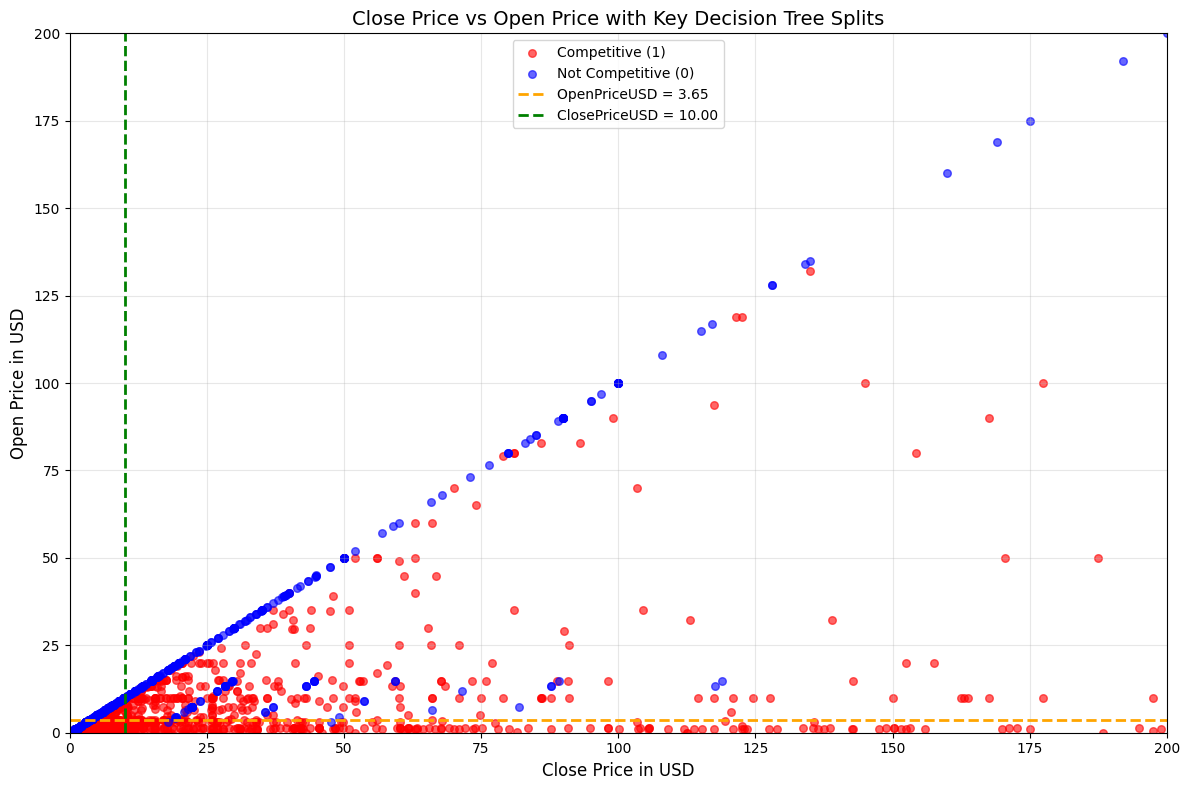

In [74]:
# Create a graph with only the two key decision boundaries
plt.figure(figsize=(12, 8)) # Create the scatter plot
#Competitive:
plt.scatter(df_clean[df_clean['Competitive?'] == 1]['ClosePriceUSD'],
            df_clean[df_clean['Competitive?'] == 1]['OpenPriceUSD'],
            c='red', alpha=0.6, label='Competitive (1)', s=30)

#non-Competitive:
plt.scatter(df_clean[df_clean['Competitive?'] == 0]['ClosePriceUSD'],
            df_clean[df_clean['Competitive?'] == 0]['OpenPriceUSD'],
            c='blue', alpha=0.6, label='Not Competitive (0)', s=30)

plt.axhline(y=3.65, color='orange', linewidth=2, linestyle='--', label='OpenPriceUSD = 3.65') # first decision rule
plt.axvline(x=10.00, color='green', linewidth=2, linestyle='--', label='ClosePriceUSD = 10.00') # second decision rule

plt.xlabel('Close Price in USD', fontsize=12)
plt.ylabel('Open Price in USD', fontsize=12)
plt.title('Close Price vs Open Price with Key Decision Tree Splits', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.tight_layout()
plt.show()

In [75]:

# Capture the decision rule created by the most important features rank #1 & #2
X_2d = df_clean[['ClosePriceUSD', 'OpenPriceUSD']]
y = df_clean['Competitive?']


dt_2d = DecisionTreeClassifier(
    min_samples_leaf=50,
    random_state=42,
    max_depth=5
)

dt_2d.fit(X_2d, y)

# Decision Tree Rule:
tree_rules = export_text(dt_2d,
                        feature_names=['ClosePriceUSD', 'OpenPriceUSD'],
                        decimals=2)
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- OpenPriceUSD <= 3.65
|   |--- ClosePriceUSD <= 3.65
|   |   |--- OpenPriceUSD <= 0.97
|   |   |   |--- class: 1
|   |   |--- OpenPriceUSD >  0.97
|   |   |   |--- OpenPriceUSD <= 2.38
|   |   |   |   |--- ClosePriceUSD <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ClosePriceUSD >  1.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- OpenPriceUSD >  2.38
|   |   |   |   |--- ClosePriceUSD <= 2.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ClosePriceUSD >  2.99
|   |   |   |   |   |--- class: 0
|   |--- ClosePriceUSD >  3.65
|   |   |--- OpenPriceUSD <= 2.97
|   |   |   |--- class: 1
|   |   |--- OpenPriceUSD >  2.97
|   |   |   |--- ClosePriceUSD <= 14.05
|   |   |   |   |--- class: 1
|   |   |   |--- ClosePriceUSD >  14.05
|   |   |   |   |--- class: 1
|--- OpenPriceUSD >  3.65
|   |--- ClosePriceUSD <= 10.00
|   |   |--- OpenPriceUSD <= 4.92
|   |   |   |--- class: 0
|   |   |--- OpenPriceUSD >  4.92
|   |   |   |--- ClosePrice